# Section 5: Lensing Maps

As part of the ACT data release 4 (DR4) lensing maps constructed using data from Seasons 2014-2015 are publicly available.  These maps are discussed more in depth in [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf). but this section will help users access and examine the maps. 

The two seasons of 98 GHz and 150 GHz maps are coadded to produce the input maps for the lensing estimator.  These input maps are discussed in more detail in the paper but are constructed such that point sources are masked and the beam is deconvolved.

The lensing maps can be accessed and used with the same Pixell commands implemented in previous notebooks meaning users can trim them and study small patches as needed. The available files are documented in table 3.

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to AdvACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.

> [Section 6](Section_6_delensing_param_shifts):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters

> [Section 7](Section_7_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps.

> [Section 8](Section_8_individual_maps_and_harmonic_analysis): Maps of Individual Patches and Harmonic Analysis using CAR maps

> [Section 9](Section_9_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 
 
---

## Initialize notebook

We begin by importing Pixell and other neccesary functions by running the introductory notebook.

We will also define a function eshow that plots CAR maps for us.  This function is introduced in the section 2 Notebook originally.

In [2]:
%run Section_1_Introduction.ipynb

def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

---
Table 3: Lensing Maps
---

Map File Name | Description
---|---
mc_corrected_realKappaCoadd_s14&15_deep56New.fits | Deep 56 lensing map
mc_corrected_realKappaCoadd_s14&15_bossNew.fits | Boss North lensing map
mc_corrected_realKappaCoadd_sim#_s14&15_deep56New.fits | Simulations where sim# = 001 -  511 for the deep 56 region
mc_corrected_realKappaCoadd_sim#_s14&15_bossNew.fits | Simulations where sim# = 001 -  511 for the Boss North region

---
Masks:
Masks for both regions are provided as fits files

In [3]:
lensing = enmap.read_map(path + "mc_corrected_realKappaCoadd_s14&15_deep56New.fits")

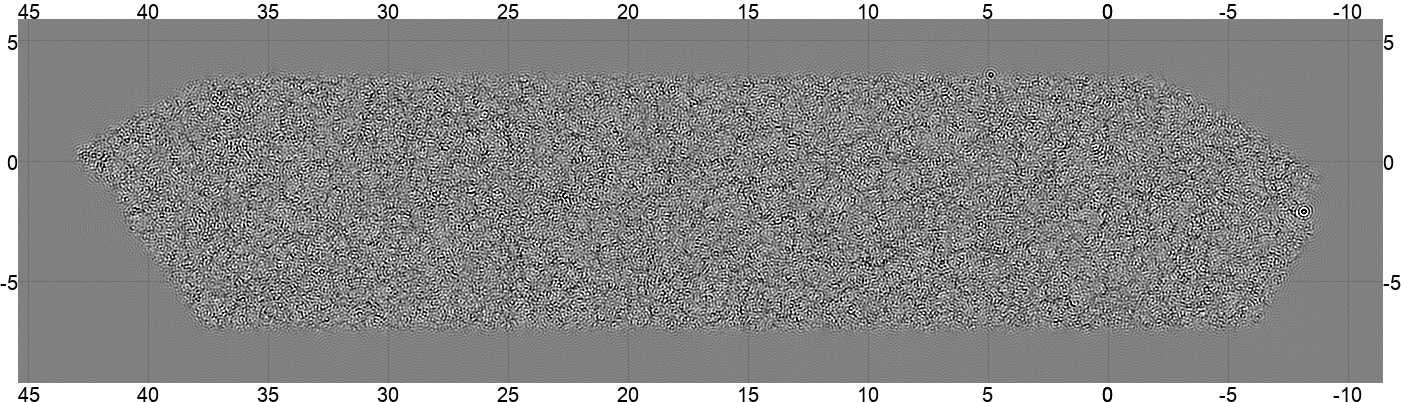

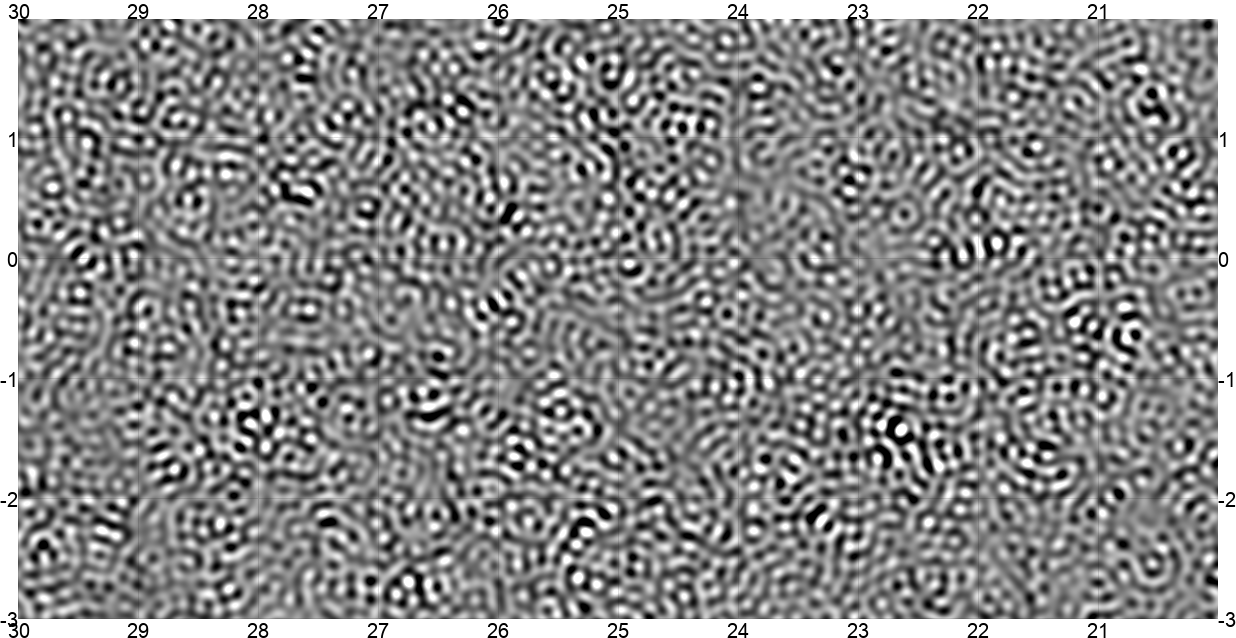

In [4]:
# Plot the entire map and thenn a smaller slice of it using the "sub" key 
eshow(lensing, **{"downgrade": 5, "ticks": 5, "color": 'gray'})
eshow(lensing,**{"sub":"-3 :2 ,30:20", "color": 'gray'} )

## Cross correlate with a galaxy over density map

These lensing maps can be cross correlated with other maps either directly in Pixell or by reprojecting to HEALPix.  For this demonstration we will cross correlate the lensing map with a galaxy overdensity map.  Since HEALPix is based on equal area pixels it is somewhat easier to build a density map in HEALPix.  In order to then cross correlate with the lesning map we will project the above CAR map to HEALPix as described in the Section 3 notebook. 

Once we've reprojected the map we can build a galaxy overdensity map using the definition
\begin{align}
g(\hat{n}) = \frac{n(\hat{n}) - \tilde n}{\tilde n} 
 \tag{1}
\end{align}

Where $n(\hat{n})$ is the number of galaxies in that pixel.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


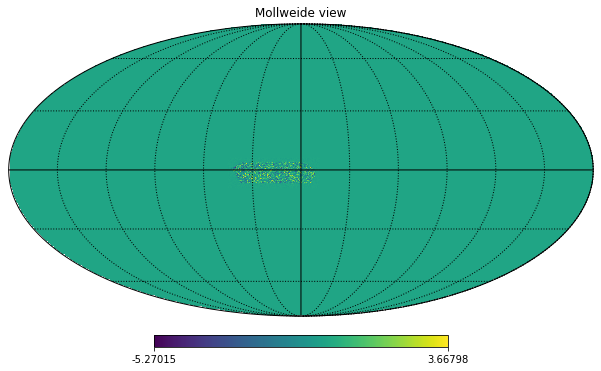

In [5]:
# Project the lensing map to HEALPix
lensing_hp =  reproject.healpix_from_enmap(lensing, lmax = 6000, nside = 624)
hp.mollview(lensing_hp)
hp.graticule()

## Make the overdensity map

To begin with we will read in a catalog of galaxies.  This can be found [here](https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz) from SDSS' BOSS catalog of CMASS galaxies.  

In [6]:
from astropy.io import fits
from astropy import units as u
redmap_hdu = fits.open(path + "galaxy_DR12v5_CMASSLOWZTOT_South.fits")

class galaxy_catalog:
    def __init__(self, catalog):
        self.RA  = catalog[1].data['RA'] *u.deg
        self.DEC = catalog[1].data['DEC']*u.deg
        

redmap = galaxy_catalog(redmap_hdu)

### Generating an over density map using the catalog

Now that we have the catalog we can generate an over density map by first creating an enmap the same shape and size as the lensed map but filled with zeros.  From there we can find the pixel location of each galaxy and add the galaxies to our empty map.  We then finish by subtracting the mean from each pixel and dividing by the mean as indicated by equation 1 above.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


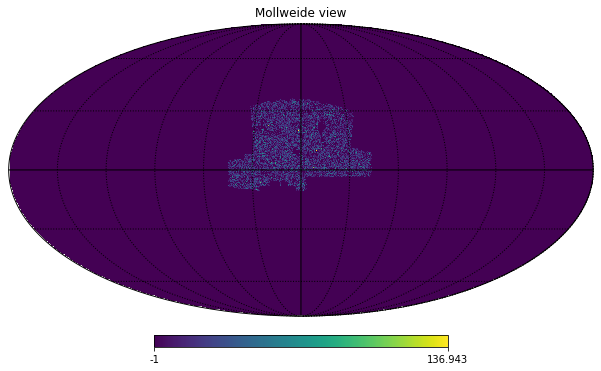

In [7]:
nside = 624
class catMapper():
    def __init__(self,ras_deg,decs_deg, weights = None):
            self.nside = nside
            self.shape = hp.nside2npix(nside)
            self.pixs = hp.ang2pix(nside,ras_deg,decs_deg,lonlat=True)
            self.counts = self.get_map(weights=weights)

    def get_map(self,weights=None):
        return np.histogram(self.pixs,bins=self.shape,weights=weights,range=[0,self.shape],density=False)[0].astype(np.float32)

mean = catMapper(redmap.RA.value, redmap.DEC.value).get_map().mean()
galaxyMap = (catMapper(redmap.RA.value, redmap.DEC.value).get_map()- mean)/mean

hp.mollview(galaxyMap)
hp.graticule()


### Cross correlate

Now that we are able to visualize the lensed map as well as the galaxy map we can cross correlate them.  The cross correlation process in Pixell is discussed in greater detail in Notebooks 7 and 8 so for a more indepth understanding of the process we encourage you to consult those notebooks.

For now we note that this is done by apodizing the maps and then using a Fourier transform approach to calculate the cross spectrum between the two maps. 

We also need to take into account the mask that has been applied to the maps.  Ordinarily one can correct for the effects of masking using
$$C_L -> \frac{C_L}{\langle W\rangle} $$
However the lensing maps already have a window applied to them before the reconstruction takes place and so to correctly account for the window we need to remove the CMB window correction ($W_c$) and then correct for both the CMB and Lensing windows.  If we are only applying a window to the galaxy map, as we'll do here, we can use:
$$ C_L -> \frac{\langle W_c^2\rangle}{\langle W_c^2 W_L\rangle} C_L$$
If you would like to apply a mask to both maps you would instead use the relation:
$$ C_L -> \frac{\langle W_c^2\rangle}{\langle W_c^2 W_L^2\rangle} C_L$$

This means we need to use the lensing map window which is provided as part of the release. In the following section we will load the lensing map window.  We will then find the $\langle W_c^2\rangle$. From there we apply a new window ($W_L$) to the maps and calculate $\langle W_c^2 W_L\rangle$.

In [8]:
# Read in the lensing map window and convert it to HEALPix form
mask = enmap.read_map(path + "mask_s14&15_deep56.fits")
W_c = reproject.healpix_from_enmap(mask, lmax = 6000, nside = nside)

# Calculate the mean of the window squared
W_c_mean = np.mean(W_c**2)

# Apply a new window to the maps by trimming the mask to a smaller size and then tapering it
# We then convert it to HEALPix format.

# Trim Mask
box = np.array([[-5,35],[2,0]])*utils.degree
mask_new = mask.submap(box)

# Define taper using enmap.apod 
apod_pix = 100 
taper    = enmap.apod(mask_new*0+1,apod_pix)
W_L = reproject.healpix_from_enmap(taper, lmax = 6000, nside = nside)

# Calculate the new window correction
W_c_W_L_mean = np.mean(W_c**2*W_L)

# Combine our two window corrections factors
win = W_c_mean/W_c_W_L_mean

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### Cross Correlate the maps

Now that we have the correct masks applied and the mask correction factor we can begin to cross correlate the two maps.  Since we have two HEALPix maps we can follow the usual cross correlation procedures and use anafast to get $C_\ell$.  This is actually slightly different to the method using in [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf).  Those results are based on Fourier transforms in Pixell, however, we choose to present a Healpix based example so that users who are more familiar with Healpix can easily follow our approach.

In [9]:
# Use anafast to generate cls
# Note we multiply both maps by the window we established above and then multiply by the "win" factor
# to correct for this new window.

cl  = hp.anafast(galaxyMap*W_L, lensing_hp)*win
ell = np.arange(len(cl))

# Bin the resulting spectra as well as the ell values
bins      = np.linspace(50, 1500, 15)
digitized = np.digitize(ell, bins)
cl_binned  = [cl[digitized == i].mean() for i in range(1, len(bins))]
ell_binned = [ell[digitized == i].mean() for i in range(1, len(bins))]

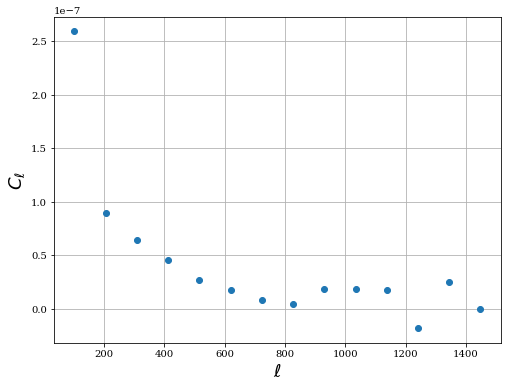

In [10]:
# Now plot the quick powerspectrum we just made
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.plot(ell_binned,cl_binned,marker="o",ls="none")
plt.xlabel('$\\ell$', fontsize = 18)
plt.ylabel('$C_{\\ell}$', fontsize = 18)
plt.grid(True)
plt.show()

We definitely see a signal here that tapers off and approaches zero for higher $\ell$ values but is above zero for low $\ell$, which is exactly what we expect to see.  We notice some fluctuations and of course we recognize that this quick cross correlation has only been done for D56 instead of for D56 and BN as is done in [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf).

# Continue to next Section

[Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps.